# Different techniques in Deep Learning with PyTorch

## Optimization methods

### Vanilla Gradient Descent

Every day in our life we always try to optimize some value, e. g. how to have lunch with minimal cost or where to go for a walk with potential girlfriend without significant expenses. Everyone optimizes something.

Thanks to mathematics we may reformulate our task in terms of functions and using calculus find some local (or better global) optima. Suppose we want to find minima of function $f:\mathbb{R}^n\to\mathbb{R}$, i. e.

$$
f(x)\to\min_x
$$

Suppose also that our function has the first derivative $f^\prime$ or more precisely *gradient* $\nabla{}f$ (if not, follow the *Reinforcement Learning* course). One can show, that the direction $\nabla{}f$ is the direction in which the function $f$ growth faster. So we obtain a simple method to find local (or global if we know the function has only one) optima called **Gradient Descent (GD)**:

$$
x_{n+1}=x_n-\tau\nabla{}f(x_n),
$$

starting with arbitrary $x_0$.

In machine learning we always optimize some *error (loss)* function $\mathcal{L}$. Given dataset $X=\{(x_i, y_i)\}_{i=1}^N$ we need to find some decision function $f$ that minimizes error

$$
\mathcal{L}(X;f)\to\min_f
$$

Always $\mathcal{L}(X;f)$ has the form of $\mathcal{L}(X;f)=\frac{1}{N}\sum_{i=1}^N\mathcal{L}_i(X;f)$, where $\mathcal{L}_i(X; f)=\mathcal{l}(x_i, y_i;f)$ some loss function on sample $i$. E. g. 

- $\mathcal{l}(x_i, y_i;f)={|f(x_i)-y_i|}^2$ for linear regression
- $\mathcal{l}(x_i, y_i;f)=\log(1+\exp(-y_if(x_i)))$ for logistic regression

It's hard to search in function space, so we parametrize our function $f$ with $\theta$ from some special functional classes. E. g. $f$ is a linear function, then $f(x)$ is simply $\langle{}w, x\rangle$ with $\theta=w$. So we can rewrite GD for loss as:

$$
\mathcal{L}(X;\theta)=\frac{1}{N}\sum_{i=1}^N\mathcal{L}_i(X; \theta)\to\min_\theta
$$

Let's try it with PyTorch! Import all necessary libraries and frameworks.

In [1]:
import os
import inspect


import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


import tqdm

Let's do our experiments on MNIST dataset. Yes, we all adore it :)

In [20]:
    trans = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5,), (1.0,)),
        ]
    )
train_set = torchvision.datasets.mnist.MNIST(root='./data', train=True, transform=trans, download=True)
train_set

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(1.0,))
                         )
    Target Transforms (if any): None

In [28]:
def get_mnist(root='./data', shuffle=True, batch_size=None, num_subset=None):
    if not os.path.exists(root):
        os.mkdir(root)
        
    trans = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5,), (1.0,)),
        ]
    )

    train_set = torchvision.datasets.mnist.MNIST(
        root=root, train=True, transform=trans, download=True)
    train_set.train_data = train_set.train_data[:num_subset]
    test_set = torchvision.datasets.mnist.MNIST(
        root=root, train=False, transform=trans, download=True)
    test_set.train_data = test_set.test_data[:num_subset]
    if not shuffle:
        sort_by_labels(train_set)
        sort_by_labels(test_set)
        
    train_set = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size if batch_size is not None else len(train_set),
        shuffle=shuffle)
    test_set = torch.utils.data.DataLoader(
        test_set,
        batch_size=32,
        shuffle=False)
    
    return train_set, test_set


def sort_by_labels(data):
    sorted_labels_indices = None
    for name, member in inspect.getmembers(data):
        if 'label' in name:
            sorted_labels_indices = torch.argsort(getattr(data, name))
            label_name = name
    
    assert not sorted_labels_indices is None, f'Not found attribute containing `label` in {data}'

    for name, member in inspect.getmembers(data):
        if 'data' in name:
            setattr(data, label_name, getattr(data, label_name)[sorted_labels_indices])
            setattr(data, name, getattr(data, name)[sorted_labels_indices])
            

def plot_samples(data, idx=slice(0, 5), num_cols=3):
    for xs, ys in data:
        num_rows = len(xs[idx])//num_cols
        if len(xs[idx]) % num_cols: num_rows += 1
        plt.subplots(num_rows, 3, figsize=(min(16, 4*num_cols), 2*num_rows))
        for i, (x, y) in enumerate(zip(xs[idx], ys[idx])):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.title(f'{y.item()}')
            plt.imshow(x.numpy().squeeze())
            plt.axis('off')
        break

Before start, we need to see on the given data.

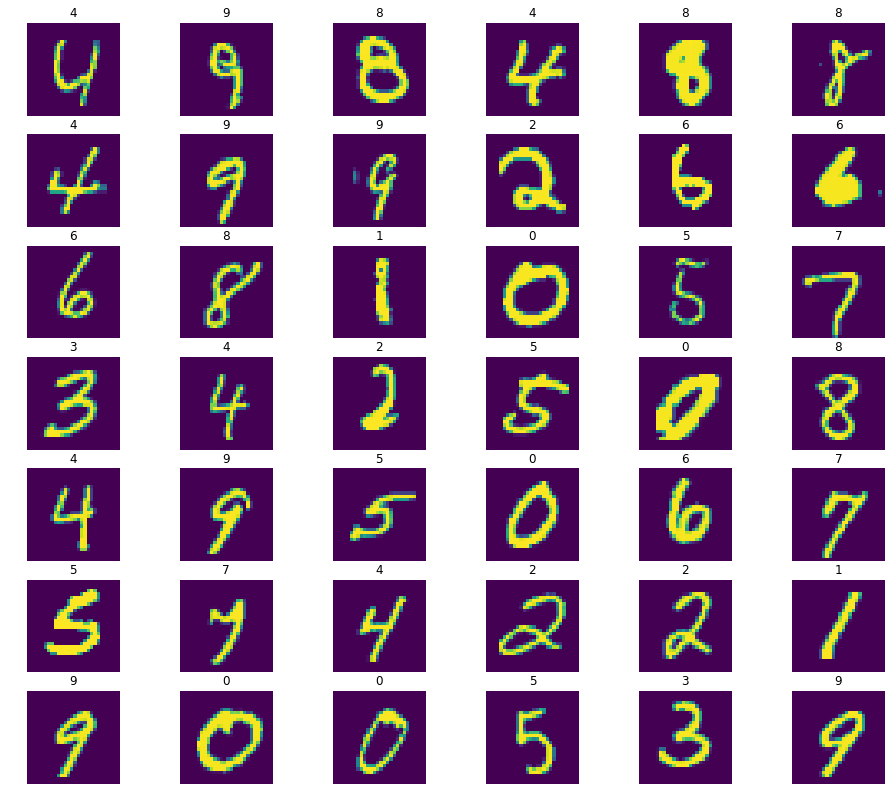

In [3]:
train, test = get_mnist()
plot_samples(train, idx=slice(0,42), num_cols=6)

Write simple fullconnected neural network working with all pixels as features.

In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)


class FCNet(nn.Module):
    def __init__(self, in_features, n_classes, hidden=32):
        super().__init__()
        
        self.features = nn.Sequential(
            Flatten(),
            nn.Linear(in_features=in_features, out_features=hidden),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=hidden, out_features=hidden),
            nn.ReLU(inplace=True),
        )
        
        self.clf = nn.Linear(in_features=hidden, out_features=n_classes)
        
    def forward(self, x):
        features = self.features(x)
        logits = self.clf(features)
        
        return logits

Generic class for training and evaluating the model.

In [52]:
class Trainer:
    def train(self,
              model,
              opt,
              train_data,
              loss_fn,
              metric_fn,
              device,
              scheduler=None,
              dev_data=None,
              num_epochs=15,):
        model.to(device)
        train_loss, train_metric = [], []
        dev_loss = dev_metric = None
        if dev_data is not None:
            dev_loss, dev_metric = [], []
        for epoch in range(1, num_epochs + 1):
            model.train()
            desc = f'[ Training.. {epoch}/{num_epochs} ]'
            train_epoch_loss, train_epoch_metric = self.epoch_step(
                model=model,
                data=train_data,
                loss_fn=loss_fn,
                metric_fn=metric_fn,
                opt=opt,
                scheduler=scheduler,
                device=device,
                desc=desc)
            train_loss.append(train_epoch_loss)
            train_metric.append(train_epoch_metric)
        
            if dev_data is not None:
                dev_epoch_loss, dev_epoch_metric = self.test(
                    model=model,
                    test_data=dev_data,
                    loss_fn=loss_fn,
                    metric_fn=metric_fn,
                    device=device,
                    desc=f'[ Validating.. {epoch}/{num_epochs} ]')
                dev_loss.append(dev_epoch_loss)
                dev_metric.append(dev_epoch_metric)
            
            self.show_results_ipython(train_loss, train_metric,
                                      dev_loss, dev_metric)
            
    def test(self,
             model,
             test_data,
             loss_fn,
             metric_fn,
             device,
             desc=f'[ Testing.. ]'):
        with torch.no_grad():
            model.eval()
            test_loss, test_metric = self.epoch_step(
                model=model,
                data=test_data,
                loss_fn=loss_fn,
                metric_fn=metric_fn,
                desc=desc,
                device=device)
            
        return test_loss, test_metric
    
    def epoch_step(self,
                   model,
                   data,
                   loss_fn,
                   metric_fn,
                   device,
                   opt=None,
                   scheduler=None,
                   desc=''):
        logits, targets = [], []
        epoch_loss = num_batches = 0
        titer = tqdm.tqdm(data, leave=False, mininterval=1, desc=desc, postfix={'loss': 0, 'metric': 0})
        for inputs, target in titer:
            inputs, target = inputs.to(device), target.to(device)
            logit = model(inputs)
            loss = loss_fn(logit, target)
            epoch_loss += loss.item()
            
            if opt is not None:
                opt.zero_grad()
                loss.backward()
                opt.step()

            logits.append(logit)
            targets.append(target)
            num_batches += 1
            
            titer.set_postfix({'loss': epoch_loss/num_batches,
                               'metric': metric_fn(logit, target)})
        if scheduler is not None:
            scheduler.step()
            
        epoch_loss /= num_batches
        logits, targets = torch.cat(logits), torch.cat(targets)
        epoch_metric = metric_fn(logits, targets)
        
        
        
        return epoch_loss, epoch_metric
    
    def show_results_ipython(self,
                             train_loss,
                             train_metric,
                             dev_loss=None,
                             dev_metric=None):
        from IPython.display import clear_output
        
        clear_output(True)
        
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.title('Loss')
        plt.plot(train_loss, label=f'train ({train_loss[-1]:.3})')
        if dev_loss is not None:
            plt.plot(dev_loss, label=f'dev ({dev_loss[-1]:.3})')
        plt.xlabel('Epoch #')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(ls='--')
        
        plt.subplot(1, 2, 2)
        plt.title('Metric')
        plt.plot(train_metric, label=f'train ({train_metric[-1]:.3})')
        if dev_metric is not None:
            plt.plot(dev_metric, label=f'dev ({dev_metric[-1]:.3})')
        plt.xlabel('Epoch #')
        plt.ylabel('Metric')
        plt.legend()
        plt.grid(ls='--')
        
        plt.show()

The final touches: loss and accuracy.

In [6]:
def cross_entropy(logit, target):
    return F.cross_entropy(logit, target)


def accuracy(logit, target):
    proba = F.softmax(logit, dim=-1)
    _, pred = torch.max(proba, dim=-1)
    
    # longtensor stays longtensor, so we take item from longtensor
    return (pred == target).sum().item()/len(logit)

Let's train our model with ordinary GD (Spoiler: `batch_size` equals to `None`!).

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

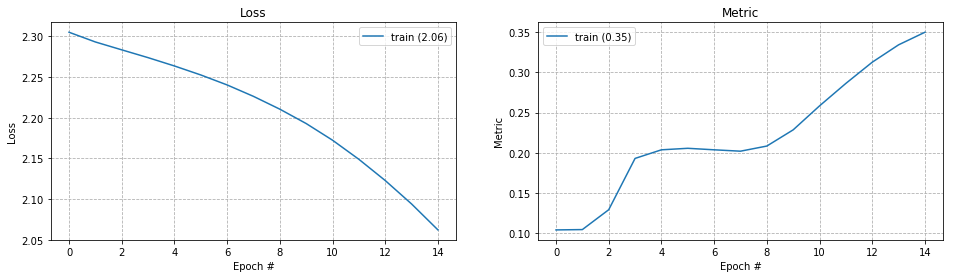

In [8]:
train, test = get_mnist(shuffle=False, batch_size=None)
shape = tuple(train.dataset.train_data.shape)[1:]

model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=0.25)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                device=device)

Evaluate on test set..

In [9]:
Trainer().test(model=model,
               test_data=test,
               loss_fn=cross_entropy,
               metric_fn=accuracy,
               device=device)

(2.019546623428028, 0.3926)

As we see, convergance rate is very slow and also it is hard to calculate the gradient of sum of $N$ elements at each iteration (with $N\approx{}10^5$. And what if $N=10^6$ or $N=10^{9}$ which is typical in deep learning? So, let's do some math!

Recall that we computing loss as

$$
\mathcal{L}(X;\theta)=\frac{1}{N}\sum_{i=1}^N\mathcal{L}_i(X; \theta).
$$

Actually, if we assume that $X=\{(x_i, y_i)\}_{i=1}^N$ is a set of *random variables* coming from some *probability distribution* $F$ (which is a (not) natural way to model our life), the value $\mathcal{L}(X;\theta)$ becomes also random variable and finding optima of random variable becomes *meaningless*! But we want to optimze it no matter what! The mathematicians syas "Ok, let's optimize some *expected value*", i. e. we will optimize $\mathbb{E}\mathcal{L}(X;\theta)$ which is a regular number, no more random. By defenition,

$$
\mathbb{E}\mathcal{L}(X;\theta)=\int\mathcal{L}(X;\theta)\,d{}F,
$$

and now the problem is how to calculate this integral with unknown distribution $F$? Almost always we don't know the distribution (of real life :). But mathematicians again have the solution to this problem: the **Law of large numbers**! It says that the huge sum of independent random variables converges to the expected value. So why we calculate $\frac{1}{N}\sum_{i=1}^N\mathcal{L}_i(X; \theta)$ instead of $\mathbb{E}\mathcal{L}(X;\theta)$ (recall $\mathcal{L}_i(X;\theta)=\mathcal{l}(x_i,y_i;\theta)$). Note, that as soon as $N$ becomes larger, the expected value becomes more accurate, and we can choose $N$ convenient between the speed of calculation and the accuracy. This called *Mini-Batch Gradient Descent* or *Stochastic Gradient Descent (SGD)*.

Let's see on SGD with small batch size.

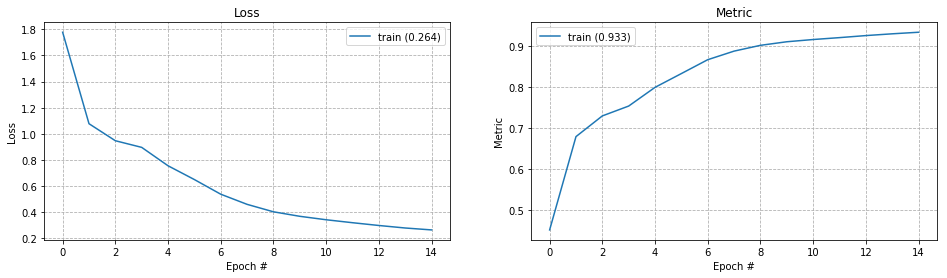

In [10]:
train, test = get_mnist(shuffle=False, batch_size=32)
shape = tuple(train.dataset.train_data.shape)[1:]

model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-3)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                device=device)

Surprisingly, we see that SGD converged faster than GD. Why do you think so happens?

Let's evaluate the model.

In [11]:
Trainer().test(model=model,
               test_data=test,
               loss_fn=cross_entropy,
               metric_fn=accuracy,
               device=device)

(4.491726391481611, 0.1325)

Hmm, there is no convergence. What is a problem? SGD doesn't work? Recall the Law of large numbers. The random variables **must be independent** and in our case we have **dependent** variables. At the beginning we have all samples consisting from ones, then twos and so on. To solve this problem we can simply shuffle the data! Let's do it. Note, we need to track not only train loss and metrics, but also test's ones.

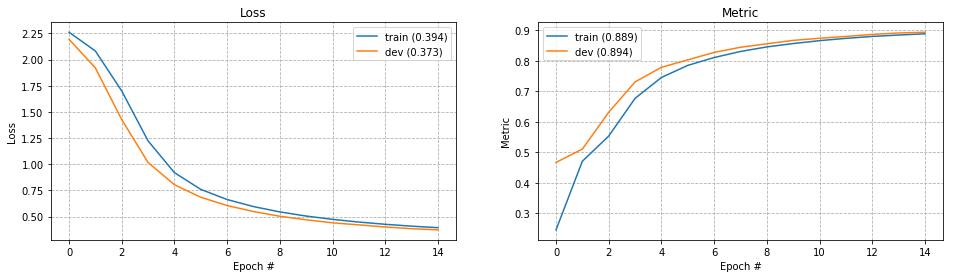

In [12]:
train, test = get_mnist(shuffle=True, batch_size=32)
shape = tuple(train.dataset.train_data.shape)[1:]

model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-3)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device)

Ok, good enough!

## Choosing appropriate learning rate

In practice we choose learning rate based on first epochs. Let's start with learning rate equals to one.

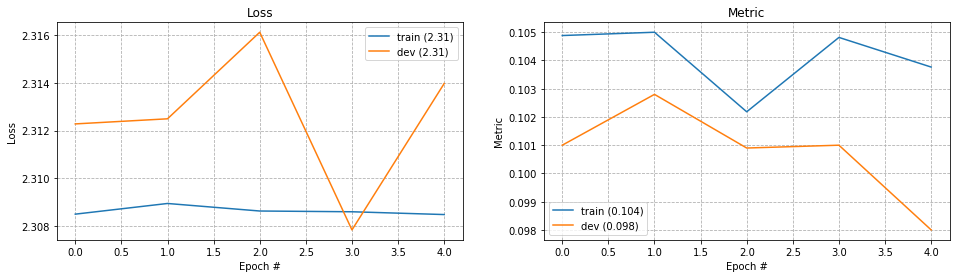

In [13]:
train, test = get_mnist(shuffle=True, batch_size=32)
shape = tuple(train.dataset.train_data.shape)[1:]

model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=3)

No convergence :( Ok, `lr=1e-1`.

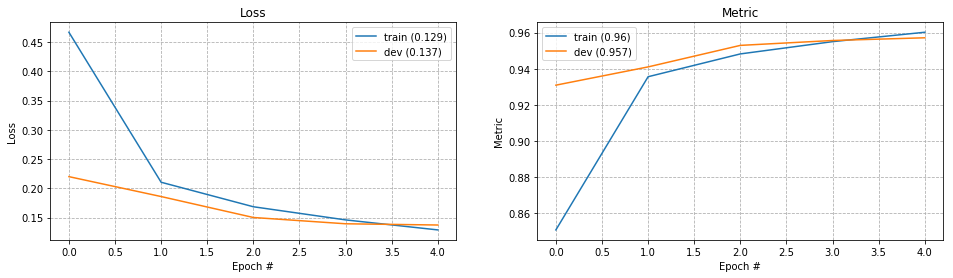

In [14]:
model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-1)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=5)

Good! What about `lr=1e-2`?

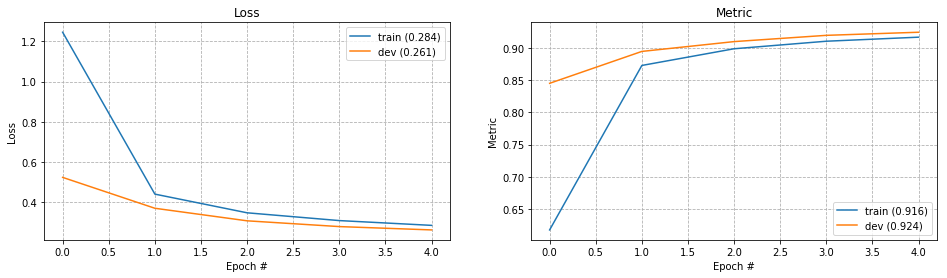

In [15]:
model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-2)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=5)

So, basing on out experiments, `lr=1e-1` is the best choice.

Another approach is to use some small subset of training set.

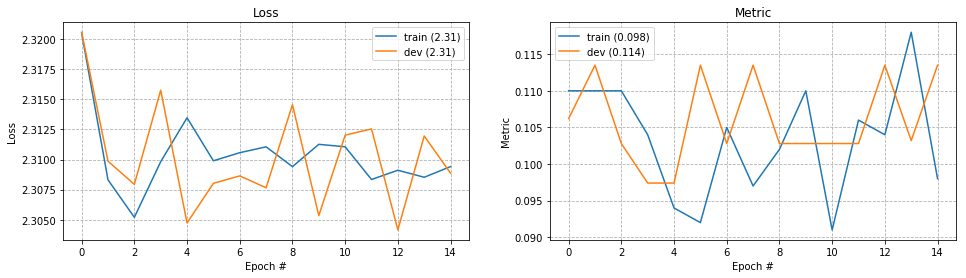

In [31]:
train, test = get_mnist(shuffle=True, batch_size=32, num_subset=1000)
shape = tuple(train.dataset.train_data.shape)[1:]

model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=15)

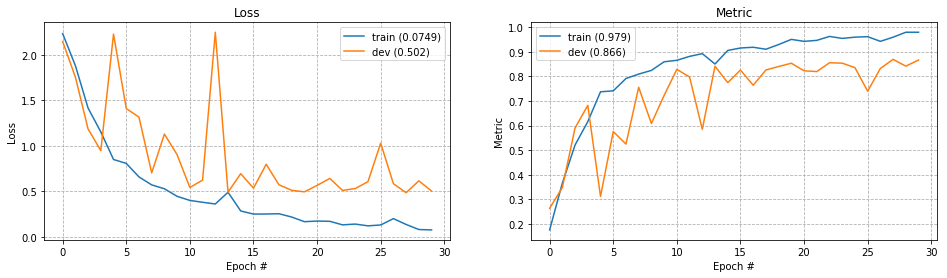

In [37]:
model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-1)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=30)

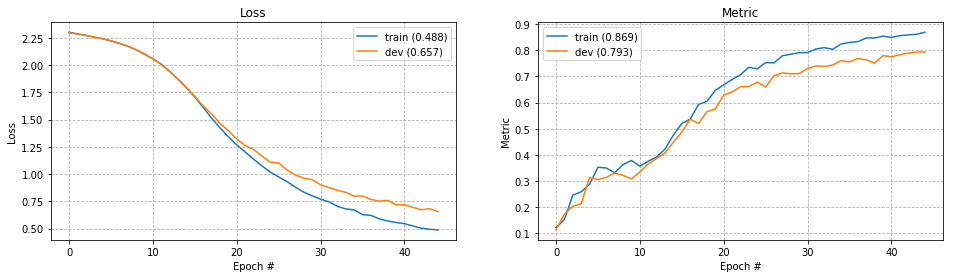

In [41]:
model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-2)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=45)

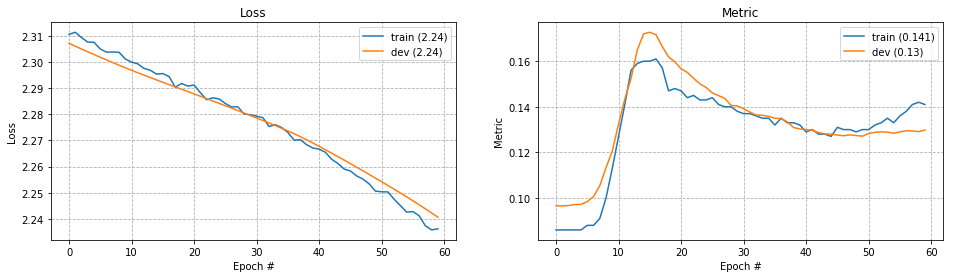

In [40]:
model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-3)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=60)

It seems that `lr=1e-1` is the best choice.

## Learning rate schedulers.

There are amount of learning rate schedulers. We will see on the simpliest one, namely `MultiStep`. It reduces learning rate by some factor at some milestones epochs. Here is training without lr scheduler.

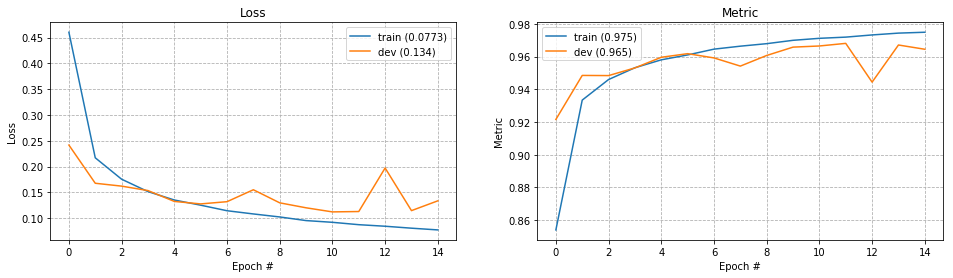

In [56]:
train, test = get_mnist(shuffle=True, batch_size=32)
shape = tuple(train.dataset.train_data.shape)[1:]

model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-1)
Trainer().train(model=model,
                opt=opt,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=15)

Let's try to reduce learning rate by $10$ times at epoch $10$.

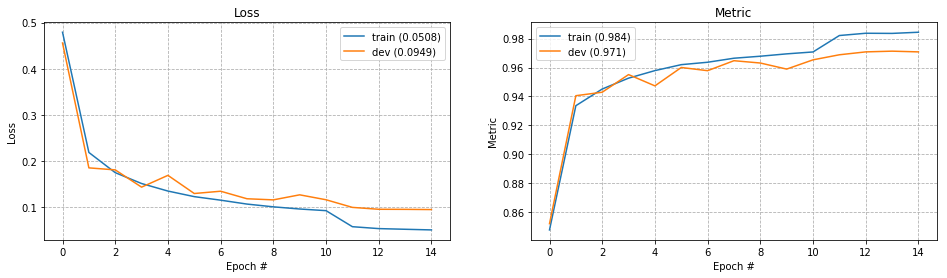

In [58]:
model = FCNet(shape[0]*shape[1], 10)
opt = torch.optim.SGD(model.parameters(), lr=1e-1)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[10])
Trainer().train(model=model,
                opt=opt,
                scheduler=lr_scheduler,
                train_data=train,
                loss_fn=cross_entropy,
                metric_fn=accuracy,
                dev_data=test,
                device=device,
                num_epochs=15)

## Averaged SGD

Simply save the intermidiate weights of model and at last epoch average all theses weights into the one model.  To save `PyTorch` model simply call `model.state_dict()` to get all weights and save elsewhere.

In [60]:
# model.state_dict()